<h2> Perturbation theory to approximate and infinite square well with a linear term V(x) = alpha x </h2>

<h3> Finding the second order pertubed energy levels for the ground state </h3>

In [ ]:
import math
import scipy.constants as sc
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA



def unperturbed_energy(n, mass, length):
    """
    Calculating the energy for any n without an added perturbation
    n       = number of excited state
    mass    = mass of particle in the well
    length  = length of the well
    """
    numerator = math.pow(n,2) * math.pow(np.pi, 2) * math.pow(sc.hbar, 2)
    denominator = 2 * mass * math.pow(length, 2)

    return numerator / denominator


def first_order_correction(alpha, length):
    """
    Calculating the first order correction.
    Found by solving ⟨1|V1|1⟩
    This correction is generalized for all n, as it does not take n into account
    """
    numerator = alpha * length

    return numerator / 2



def second_order_correction_groundstate(alpha, mass, length, max_n=10):
    """
    Calculating the second order correction for the ground state.
    Found by solving:
            a^2 SUM(m=/=n) |⟨n|V1|n⟩|^2 / E(0)n - E(0)m
    """
    # Pre-calculated constants from derivation
    numerator = -128 * mass * (length**4) * (alpha**2)
    denominator = (np.pi**6) * (sc.hbar**2)
    prefactor = numerator / denominator

    # Now summing over even n (n=2,4,6,...)
    sum_range = range(2,max_n, 2)
    sum_result = 0.0
    for n in sum_range:
        # denominator derived from (1^2 - n^2)^5
        temp = (n**2) / (((n-1)**5) * ((n+1)**5))
        sum_result+=temp

    
    return prefactor * sum_result


def energy_groundstate_second_order_perturbation(e01, e11, e21):
    """ 
    Combining the unperturbed energy with the 2 corrections for our final result
    """
    return e01 + e11 + e21



def second_order_correction_first_excited_state(alpha, mass, length, max_m):
    """
    alpha   = alpha value
    mass    = mass of particle
    length  = length of the well
    max_m   = maximum number of iterations on the sum
    """
    # Split into left-hand-side (LHS) and right-hand-side(RHS) which is the sum over even n
    numerator = -512 * mass * (length**4) * (alpha**2)
    denominator = (np.pi**6) * (sc.hbar**2)
    prefactor = numerator / denominator

    # Now summing over even n
    sum_range = range(1, max_m + 1, 2)
    sum_result = 0.0
    for n in sum_range:
        temp = (n**2) / (((n-2)**5) * ((n+2)**5))
        sum_result+=temp

    return prefactor * sum_result
    


"""
Functions for solving discretization 
"""


def V_potential(index, step_size, alpha):
    """ The linear potential V(x) = alpha * x """
    x = index * step_size
    return alpha * x

def solve_discretization(L, Steps, m, alpha):
    """
    Constructs the Hamiltonian matrix using Finite Difference Method
    and returns sorted eigenvalues.
    """
    a = L / Steps # Step size
    t = sc.hbar**2 / (2 * m * a**2) # Kinetic hopping term

    # Initialize Hamiltonian as a zero matrix
    # Size is Steps-1 because boundary conditions are 0 at ends
    size = Steps - 1
    H = np.zeros((size, size))

    for i in range(size):
        # Diagonal elements: 2*t + V(x)
        H[i, i] = 2 * t + V_potential(i+1, a, alpha)
        
        # Off-diagonal elements: -t
        if i > 0:
            H[i, i-1] = -t
        if i < size - 1:
            H[i, i+1] = -t
            
    # Calculate eigenvalues (we only need eigenvalues, not vectors)
    eigenvalues = LA.eigvalsh(H) # eigvalsh is faster for symmetric matrices
    return np.sort(eigenvalues)


def discretization(L, Steps, m, alpha):
    # define the step size
    a = L / Steps

    J = sc.hbar**2 / (2 * m * a**2)


    # We solve for the internal points (Steps-1) to enforce psi=0 at boundaries
    N_internal = Steps - 1
    H = np.zeros((N_internal, N_internal))

    for i in range(N_internal):
        # x_i corresponds to the i+1-th step because we skip the 0-th boundary
        x_i = (i + 1) * a 
        
        # Diagonal: 2J + V(x)
        H[i, i] = 2 * J + alpha * x_i
        
        # Off-diagonals: -J
        if i > 0:
            H[i, i-1] = -J
        if i < N_internal - 1:
            H[i, i+1] = -J
            
    # Directly solve for eigenvalues (pre-sorted)
    return LA.eigvalsh(H) 


6.024667394036591e-20
0.3760301621048726


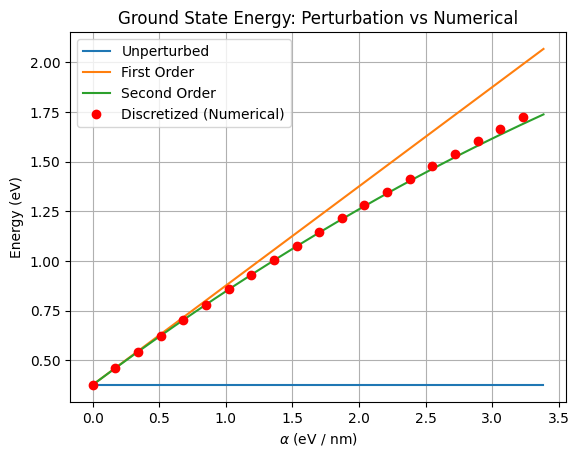

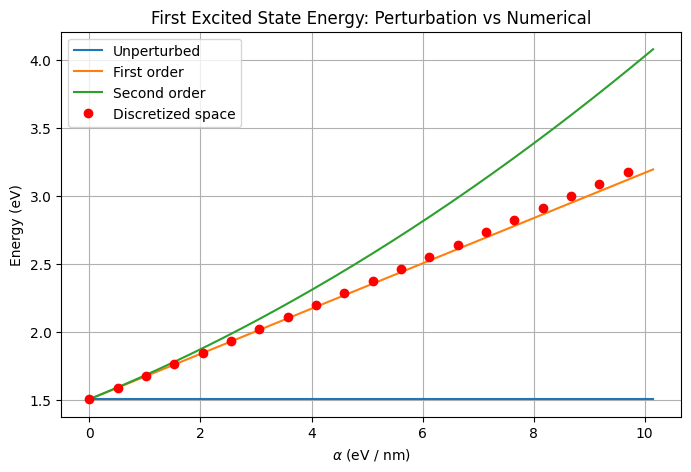

2 -0.0
4 -0.32941388555901413
6 -0.3298355353325297
10 -0.3298505425805117
20 -0.32985082171135083
50 -0.3298508232848475
1 0.32941388555901413
3 0.09887687188939369
5 0.09838687681954332
11 0.09836278362588641
21 0.09836261934494775
51 0.09836261702863486


In [34]:
particle_mass = sc.electron_mass # using an electron
well_length = 1e-9

ground_state = unperturbed_energy(1,particle_mass,well_length)
print(ground_state) # this is in joules
print(ground_state / sc.electron_volt) # this is in electron volts eV

""" 
We choose alpha such that the first-order perturbative correction becomes comparable to the unperturbed level spacing
"""
alpha_min = 0
delta_E = (3 * (np.pi**2) * (sc.hbar**2)) / (2 * particle_mass * (well_length**2))
alpha_max = delta_E  / well_length * 3
num_steps = 200
alpha_values = np.linspace(alpha_min, alpha_max, num_steps)
excited_state_zoom_factor = 3 # the first excited state alpha values need to range larger to see how the second-order changes

E0 = unperturbed_energy(1, particle_mass, well_length)
E1 = unperturbed_energy(2, particle_mass, well_length)
N = 100 # amount of discretized steps per wave function

# list of ground state energies for different alphas
E_ground = []
E_firstexcited = []
Ground_discretized = []
Excited_discretized = []


for index,alpha in enumerate(alpha_values):
    # Energy levels for the ground state
    E1n = first_order_correction(alpha, well_length)    # E(1)n, as this is the same for all states
    E21 = second_order_correction_groundstate(          # E(2)1 
        alpha,
        particle_mass,
        well_length,
        max_n=50
    )
    

    E_ground.append(E0 + E1n + E21)
    # energy levels for the first excited state
    E22 = second_order_correction_first_excited_state(
        alpha * excited_state_zoom_factor,
        particle_mass,
        well_length,
        max_m=50
    )
    
    E_firstexcited.append(E1 + E1n + E22)

    # energy levels for discretized space, only save a couple of points
    if(index % 10 == 0):
        singleResult = sorted(discretization(well_length, N, particle_mass, alpha))
        Ground_discretized.append(singleResult[0]/sc.electron_volt)
        Excited_discretized.append(singleResult[1]/sc.electron_volt)


# Array of all ground-state energy levels in joules for range of alpha values
E_ground = np.array(E_ground)
E_firstexcited = np.array(E_firstexcited)

# Converting joules to eV
E_ground_ev = E_ground / sc.electron_volt
E_firstexcited_ev = E_firstexcited / sc.electron_volt 

# Convert alpha (J/m) to (eV/nm)
# Divide by elementary charge to get eV/m, then by 1e9 to get eV/nm
alpha_ev_per_nm = alpha_values / (sc.electron_volt * 1e9)
alpha_ev_per_nm_excited = (alpha_values * excited_state_zoom_factor) / (sc.electron_volt * 1e9)


# creating a list of energy values with only the first correction applied, in eV
E_first_only_ev_ground = (E0 + alpha_values * well_length / 2) / sc.electron_volt
E_first_only_ev_firstexcited = (E1 + ((alpha_values * well_length) / 2)) / sc.electron_volt

# Plotting for the ground state
plt.figure()
plt.title('Ground State Energy: Perturbation vs Numerical') # Added Title
plt.plot(alpha_ev_per_nm, E0 / sc.electron_volt * np.ones_like(alpha_values),label='Unperturbed') # unperturbed energy
plt.plot(alpha_ev_per_nm, E_first_only_ev_ground, label='First Order') # first-order correction
plt.plot(alpha_ev_per_nm, E_ground_ev, label='Second Order')  # second-order correction
plt.plot(alpha_ev_per_nm[::10], Ground_discretized, 'ro', label='Discretized (Numerical)') # we need to take a slice of the alpha per eV set

plt.xlabel(r'$\alpha$ (eV / nm)')
plt.ylabel('Energy (eV)')
plt.legend()
plt.grid(True)
plt.show()


# Plotting for the first excited state
plt.figure(figsize=(8,5))
plt.title('First Excited State Energy: Perturbation vs Numerical') # Added Title
plt.plot(alpha_ev_per_nm_excited, E1 / sc.electron_volt * np.ones_like(alpha_values)) # unperturbed energy
plt.plot(alpha_ev_per_nm_excited, E_first_only_ev_firstexcited) # first order correction
plt.plot(alpha_ev_per_nm_excited, E_firstexcited_ev)
plt.plot(alpha_ev_per_nm_excited[::10], Excited_discretized, 'ro')

plt.xlabel(r'$\alpha$ (eV / nm)')
plt.ylabel('Energy (eV)')
plt.legend(['Unperturbed', 'First order', 'Second order', 'Discretized space'])
plt.grid(True)
plt.show()

for max_n in [2, 4, 6, 10, 20, 50]:
    E2 = second_order_correction_groundstate(alpha_max, particle_mass, well_length, max_n)
    print(max_n, E2 / sc.electron_volt)

for max_m in [1, 3, 5, 11, 21, 51]:
    E22 = second_order_correction_first_excited_state(
        alpha_max,
        particle_mass,
        well_length,
        max_m=max_m
    )
    print(max_m, E22 / sc.electron_volt)



<h3> Plotting wave functions in an infinite square well </h3>

In [26]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
from numpy.linalg import eigh

# Physical parameters
m = sc.electron_mass
L = 1e-9
N = 400  # grid points (increase for smoother curves)

x = np.linspace(0, L, N)
dx = x[1] - x[0]

# Kinetic energy matrix
coeff = sc.hbar**2 / (2 * m * dx**2)
T = coeff * (
    2 * np.eye(N)
    - np.eye(N, k=1)
    - np.eye(N, k=-1)
)

def hamiltonian(alpha):
    V = np.diag(alpha * x)
    return T + V

def compute_wavefunctions(alpha):
    H = hamiltonian(alpha)
    energies, states = eigh(H)
    return energies, states


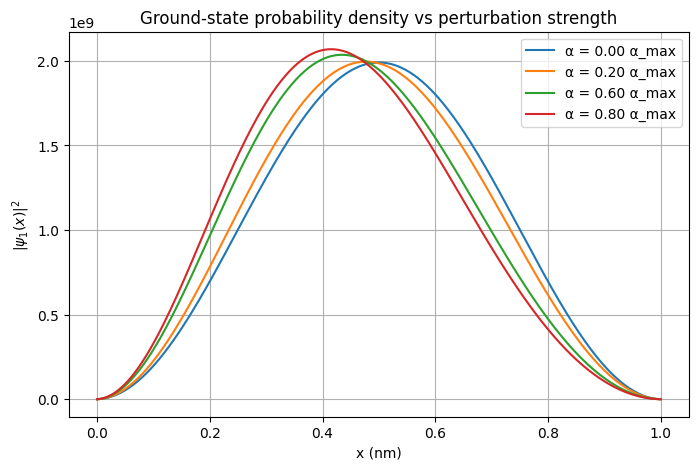

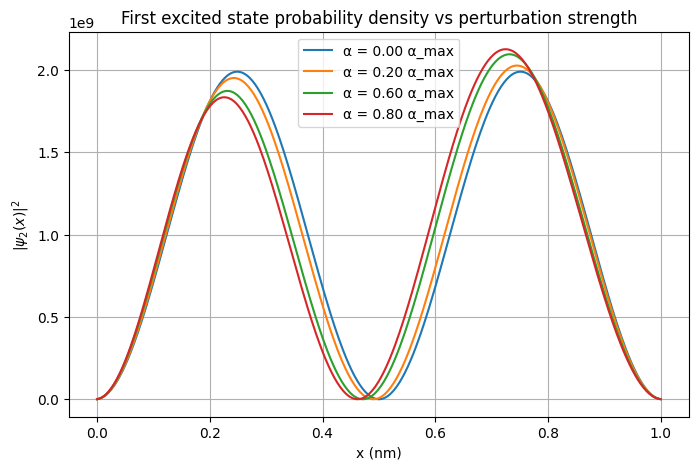

In [27]:
alpha_values = [0, 0.2, 0.6, 0.8]  # in units of alpha_max
delta_E = (3 * np.pi**2 * sc.hbar**2) / (2 * m * L**2)
alpha_max = delta_E / L
alpha_values = [a * alpha_max for a in alpha_values]

plt.figure(figsize=(8,5))

for alpha in alpha_values:
    E, psi = compute_wavefunctions(alpha)
    psi1 = psi[:, 0]
    psi1 /= np.sqrt(np.trapezoid(psi1**2, x))  # normalize

    plt.plot(x * 1e9, psi1**2, label=f'α = {alpha/alpha_max:.2f} α_max')

plt.xlabel('x (nm)')
plt.ylabel(r'$|\psi_1(x)|^2$')
plt.title('Ground-state probability density vs perturbation strength')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8,5))

for alpha in alpha_values:
    E, psi = compute_wavefunctions(alpha)
    psi1 = psi[:, 1]
    psi1 /= np.sqrt(np.trapezoid(psi1**2, x))  # normalize

    plt.plot(x * 1e9, psi1**2, label=f'α = {alpha/alpha_max:.2f} α_max')

plt.xlabel('x (nm)')
plt.ylabel(r'$|\psi_2(x)|^2$')
plt.title('First excited state probability density vs perturbation strength')
plt.legend()
plt.grid(True)
plt.show()


<h3> Justifying truncation </h3>

In [ ]:
def E0(n, mass, L):
    """Unperturbed energy eigenvalues for the infinite square well."""
    return (n**2 * np.pi**2 * sc.hbar**2) / (2 * mass * L**2)

def x_me_1(m, L):
    # <m|x|1> for even m (0 for odd m)
    if m % 2 == 1:
        return 0.0
    return -(8 * m * L) / (np.pi**2 * (m-1)**2 * (m+1)**2)

def term_ground(m, alpha, mass, L):
    """
    Calculates a single term of the second-order sum: |<m|V|1>|^2 / (E1 - Em)
    Note: Since E1 < Em for all m, every term here will be negative.
    """
    if m == 1:
        return 0.0
    xm1 = x_me_1(m, L)
    if xm1 == 0.0:
        return 0.0
    denom = E0(1, mass, L) - E0(m, mass, L)
    return (alpha**2) * (xm1**2) / denom

def x_me_2(m, L):
    # <m|x|2> for odd m (0 for even m)
    if m % 2 == 0:
        return 0.0
    return -(16 * m * L) / (np.pi**2 * (m-2)**2 * (m+2)**2)

def term_excited(m, alpha, mass, L):
    """
    Calculates single term for excited state correction.
    Physics Note: 
      - When m=1: (E2 - E1) is positive -> Energy pushed UP (Repulsion)
      - When m>2: (E2 - Em) is negative -> Energy pushed DOWN
    """
    if m == 2:
        return 0.0
    xm2 = x_me_2(m, L)
    if xm2 == 0.0:
        return 0.0
    denom = E0(2, mass, L) - E0(m, mass, L)
    return (alpha**2) * (xm2**2) / denom

particle_mass = sc.electron_mass
L = 1e-9

# Scaling alpha to be comparable to the energy gap
delta_E = E0(2, particle_mass, L) - E0(1, particle_mass, L)
alpha_max = delta_E / L  # your chosen scaling

alpha = alpha_max


# Ground state terms: m = 2,4,6,... up to M
M_ground = 50
m_vals_g = np.arange(2, M_ground+1, 2)
terms_g = np.array([term_ground(m, alpha, particle_mass, L) for m in m_vals_g])
partials_g = np.cumsum(terms_g)

# First excited terms: m = 1,3,5,... up to M
M_exc = 51
m_vals_e = np.arange(1, M_exc+1, 2)
terms_e = np.array([term_excited(m, alpha, particle_mass, L) for m in m_vals_e])
partials_e = np.cumsum(terms_e)

# Convert to eV for readability
terms_g_ev = terms_g / sc.electron_volt
partials_g_ev = partials_g / sc.electron_volt

terms_e_ev = terms_e / sc.electron_volt
partials_e_ev = partials_e / sc.electron_volt


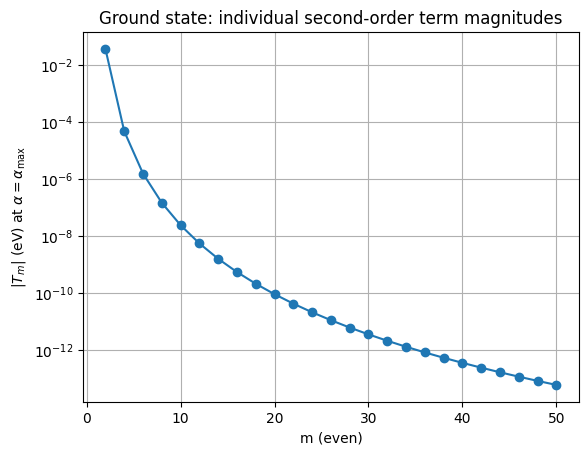

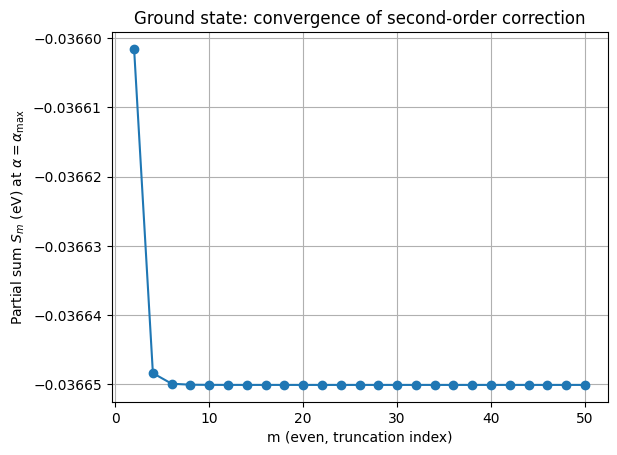

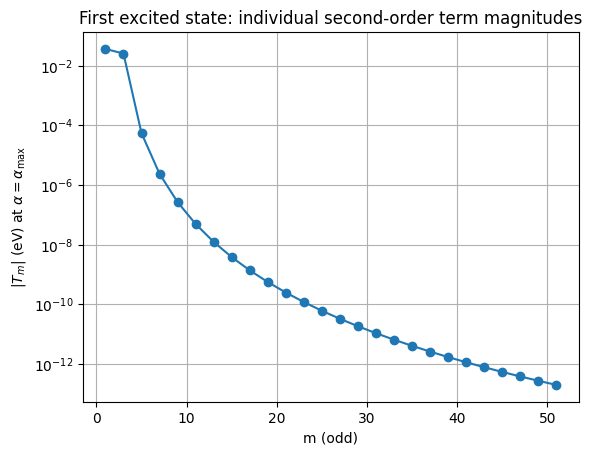

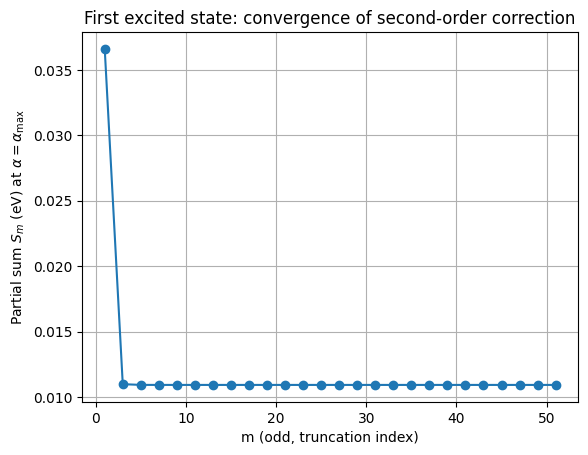

In [29]:
import matplotlib.pyplot as plt

# Individual term magnitudes (ground)
plt.figure()
plt.plot(m_vals_g, np.abs(terms_g_ev), marker='o')
plt.yscale('log')
plt.xlabel('m (even)')
plt.ylabel(r'$|T_m|$ (eV) at $\alpha=\alpha_{\max}$')
plt.title('Ground state: individual second-order term magnitudes')
plt.grid(True)
plt.show()

# Partial sum convergence (ground)
plt.figure()
plt.plot(m_vals_g, partials_g_ev, marker='o')
plt.xlabel('m (even, truncation index)')
plt.ylabel(r'Partial sum $S_m$ (eV) at $\alpha=\alpha_{\max}$')
plt.title('Ground state: convergence of second-order correction')
plt.grid(True)
plt.show()

# Individual term magnitudes (excited)
plt.figure()
plt.plot(m_vals_e, np.abs(terms_e_ev), marker='o')
plt.yscale('log')
plt.xlabel('m (odd)')
plt.ylabel(r'$|T_m|$ (eV) at $\alpha=\alpha_{\max}$')
plt.title('First excited state: individual second-order term magnitudes')
plt.grid(True)
plt.show()

# Partial sum convergence (excited)
plt.figure()
plt.plot(m_vals_e, partials_e_ev, marker='o')
plt.xlabel('m (odd, truncation index)')
plt.ylabel(r'Partial sum $S_m$ (eV) at $\alpha=\alpha_{\max}$')
plt.title('First excited state: convergence of second-order correction')
plt.grid(True)
plt.show()
